# Import libraries

In [13]:
# all necessary libraries for project
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, average_precision_score, f1_score, precision_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV

Dataset source: https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset

In [14]:
# import dataset and data preview
df = pd.read_csv("/content/secondary_data.csv", sep=";")
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


# Missing values (NaN)

In [15]:
# let's see on data more detail
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 61069 non-null  object 
 1   cap-diameter          61069 non-null  float64
 2   cap-shape             61069 non-null  object 
 3   cap-surface           46949 non-null  object 
 4   cap-color             61069 non-null  object 
 5   does-bruise-or-bleed  61069 non-null  object 
 6   gill-attachment       51185 non-null  object 
 7   gill-spacing          36006 non-null  object 
 8   gill-color            61069 non-null  object 
 9   stem-height           61069 non-null  float64
 10  stem-width            61069 non-null  float64
 11  stem-root             9531 non-null   object 
 12  stem-surface          22945 non-null  object 
 13  stem-color            61069 non-null  object 
 14  veil-type             3177 non-null   object 
 15  veil-color         

In [16]:
# let's see precent of missing values by column
percent_nan_values_df = pd.DataFrame({"col_name": [], "nan_%": [], "dtype": []})

columns_with_missing_values = [x for x in df if df[x].isnull().sum()>0]
for col in columns_with_missing_values:
  nan_count = df[col].isnull().sum()
  row_record = pd.DataFrame({"col_name": [col], "nan_%": [nan_count/df.shape[0]], "dtype": df[col].dtype})
  percent_nan_values_df = pd.concat([percent_nan_values_df, row_record], ignore_index=True)

percent_nan_values_df.sort_values(by="nan_%", ascending=False)

,col_name,nan_%,dtype
5,veil-type,0.947977,object
8,spore-print-color,0.895954,object
6,veil-color,0.878613,object
3,stem-root,0.843931,object
4,stem-surface,0.624277,object
2,gill-spacing,0.410405,object
0,cap-surface,0.231214,object
1,gill-attachment,0.161850,object
7,ring-type,0.040462,object


Based on this information, we can simply remove columns where we can observe more then 50 percent of missing values from our main dataset.
We also see that we have a column called gill distance, which has 41 percent missing data. In theory, machine learning algorithms could be used to artificially generate additional data, but not this time (because we have large amount of data and many other features)

<Axes: >

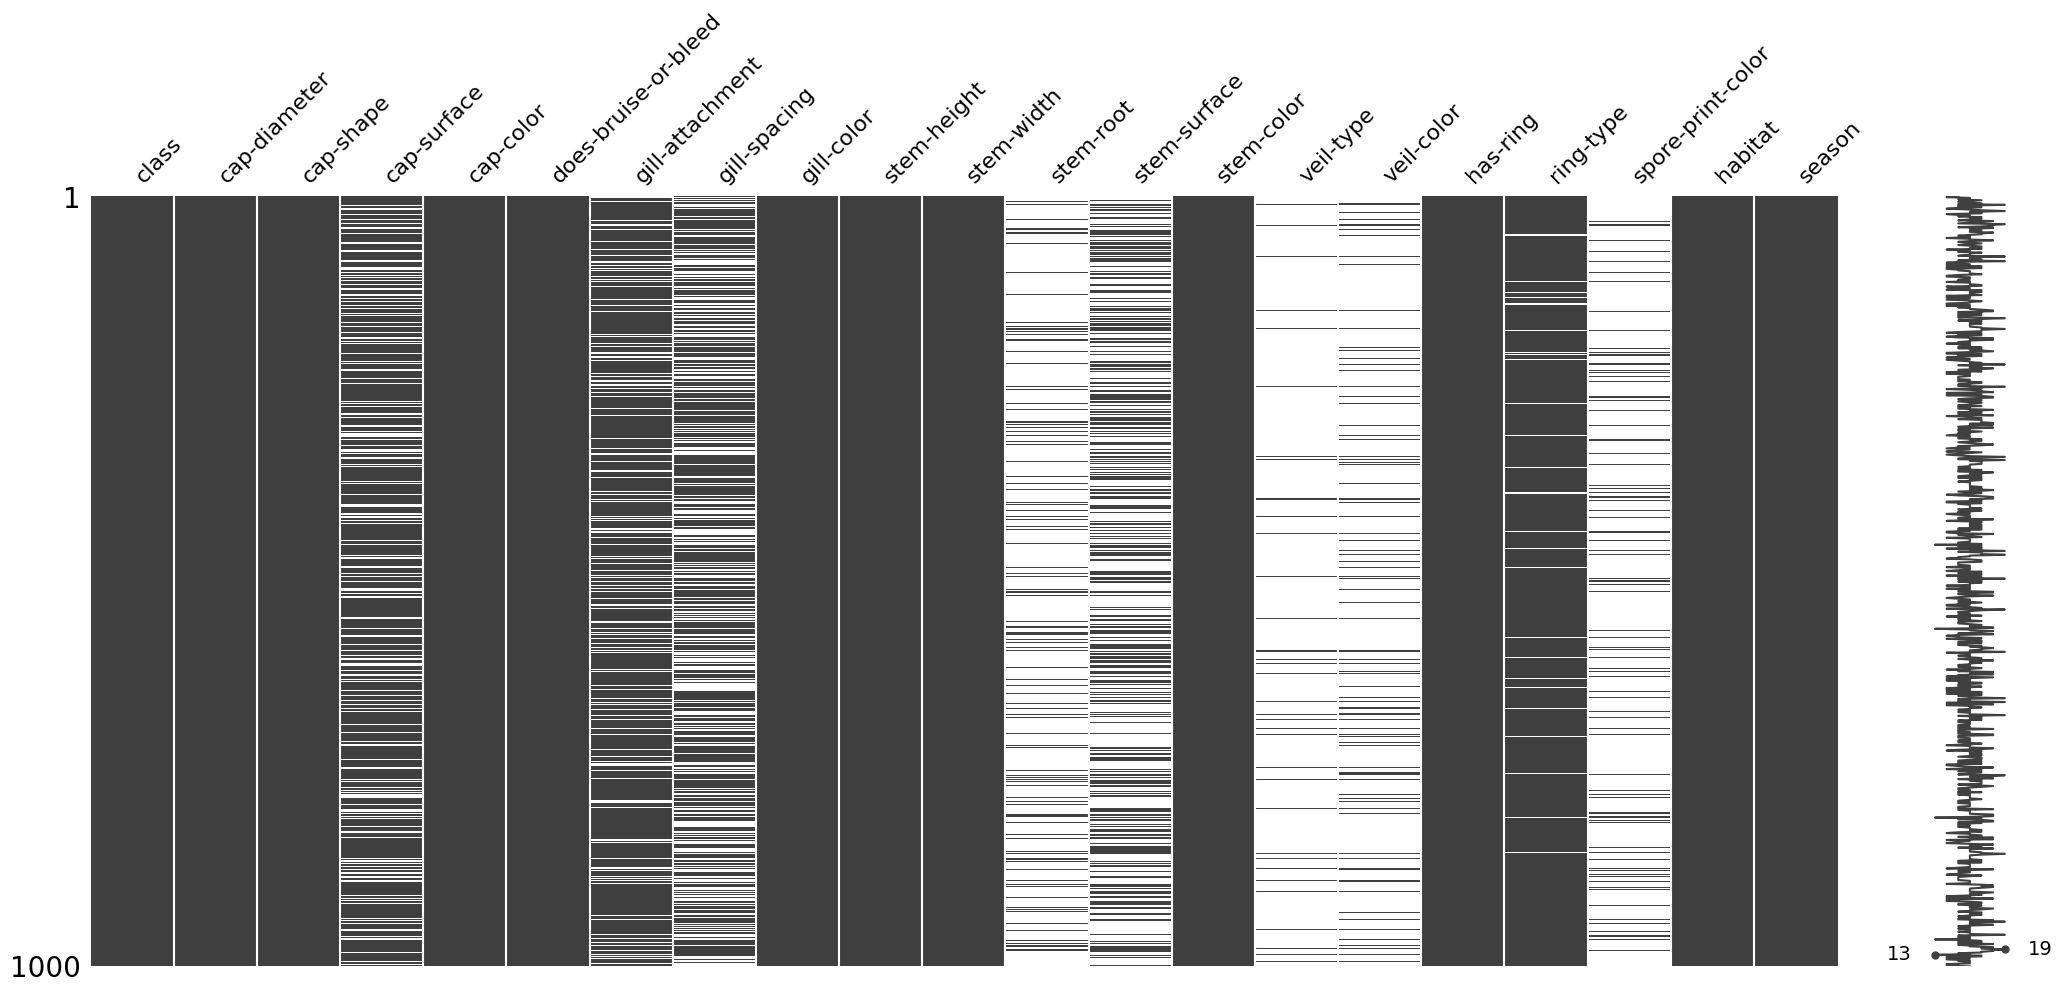

In [17]:
# also the way to present quantity of missing values in each column is graph
msno.matrix(df.sample(1000))

So here we see the same result but in the graph way

In [18]:
# drop selected columns with majority missing values
df.drop(columns=["veil-type", "spore-print-color",
                 "veil-color", "stem-root", "stem-surface", "gill-spacing"], inplace=True)

# Dealing with other missing values

Another way to deal with minority of missing values in column is simple revome this column or try to fill in these NaN values synthetically. We can use SimpleImputer (in sklearn package) or more complicated machine learning algorithms.

In [19]:
# before impute data let's check data for duplicates
print(f"quantity of duplicates in data: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

quantity of duplicates in data: 146


In [20]:
# in dataset we have 60923 records
df.shape[0]

60923

In [21]:
# so for the column "ring-type" we will use SimpleImputer
# because have really small precent of missing values

most_feq_impute = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
df["ring-type"] = most_feq_impute.fit_transform(df[["ring-type"]]).ravel()

For another missing data will be great use machine learning algorithm to fill in missings, but as we have large dataset, than firstly we try remove records with missing values and will see what we get then and make respectively decision.

In [22]:
df.dropna(subset="gill-attachment", inplace=True)
df.reset_index(drop=True, inplace=True)

df.drop(columns="cap-surface", inplace=True)
# after drop records which have missing values in gill-attachment
# i wanna to use SimpleImuter for that column, but still have 25% of missing values

# Feature preprocessing and analysis

In [23]:
cat_features_col = df.select_dtypes(include="O").columns
num_features_col = df.select_dtypes(exclude="O").columns

print(f"Categorical features: {cat_features_col}")
print(f"Numerical features: {num_features_col}")


Categorical features: Index(['class', 'cap-shape', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-color', 'stem-color', 'has-ring', 'ring-type',
       'habitat', 'season'],
      dtype='object')
Numerical features: Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object')


Since there are fewer numerical columns, we will start the analysis with them.

## Numerical data analysis

In [24]:
df.describe()

,cap-diameter,stem-height,stem-width
count,51068.000000,51068.000000,51068.000000
mean,7.056669,6.536906,12.778649
std,5.436607,3.006707,10.353747
min,0.440000,0.000000,0.000000
25%,3.770000,4.710000,5.900000
50%,6.170000,5.970000,10.680000
75%,8.740000,7.690000,16.820000
max,62.340000,27.850000,103.910000


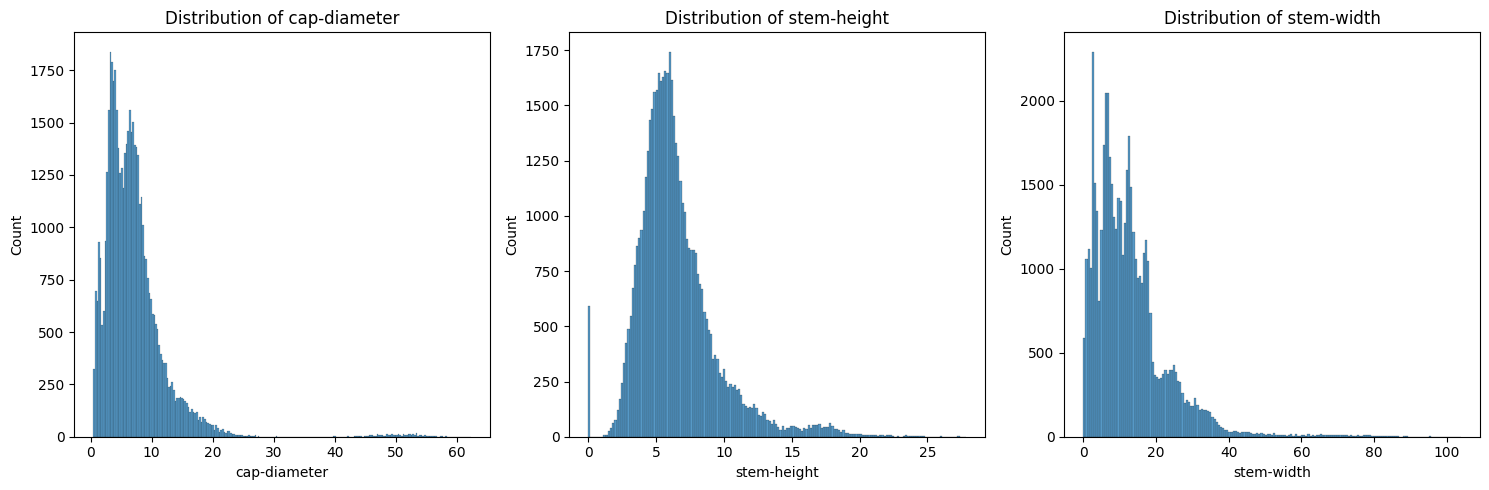

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(num_features_col):
    sns.histplot(df[col], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

You can see that on the graph there are values ​​of stem-height and stem-width, which are equal to 0, which raises suspicions.
In the stem-height situation, it is clear that this is most likely an outlier.

In [26]:
# let's see on this situation more detail
shape_height_0_width_0 = df[(df["stem-height"] == 0) & (df["stem-width"] == 0)].shape[0]
shape_height_not_0_width_0 = df[(df["stem-height"] != 0) & (df["stem-width"] == 0)].shape[0]
shape_height_0_width_not_0 = df[(df["stem-height"] == 0) & (df["stem-width"] != 0)].shape[0]


print(f"Quantity of records when stem-height equal to 0 and stem-width equal to 0: {shape_height_0_width_0}")
print(f"Quantity of records when stem-height not equal to 0 and stem-width equal to 0: {shape_height_not_0_width_0}")
print(f"Quantity of records when stem-height equal to 0 and stem-width not equal to 0: {shape_height_0_width_not_0}")

Quantity of records when stem-height equal to 0 and stem-width equal to 0: 590
Quantity of records when stem-height not equal to 0 and stem-width equal to 0: 0
Quantity of records when stem-height equal to 0 and stem-width not equal to 0: 0



From this we can conclude that stem-height and stem-width are more outliers than data specifics.

In [27]:
df = df[~((df["stem-height"] == 0) & (df["stem-width"] == 0))]

## Categorical data analysis

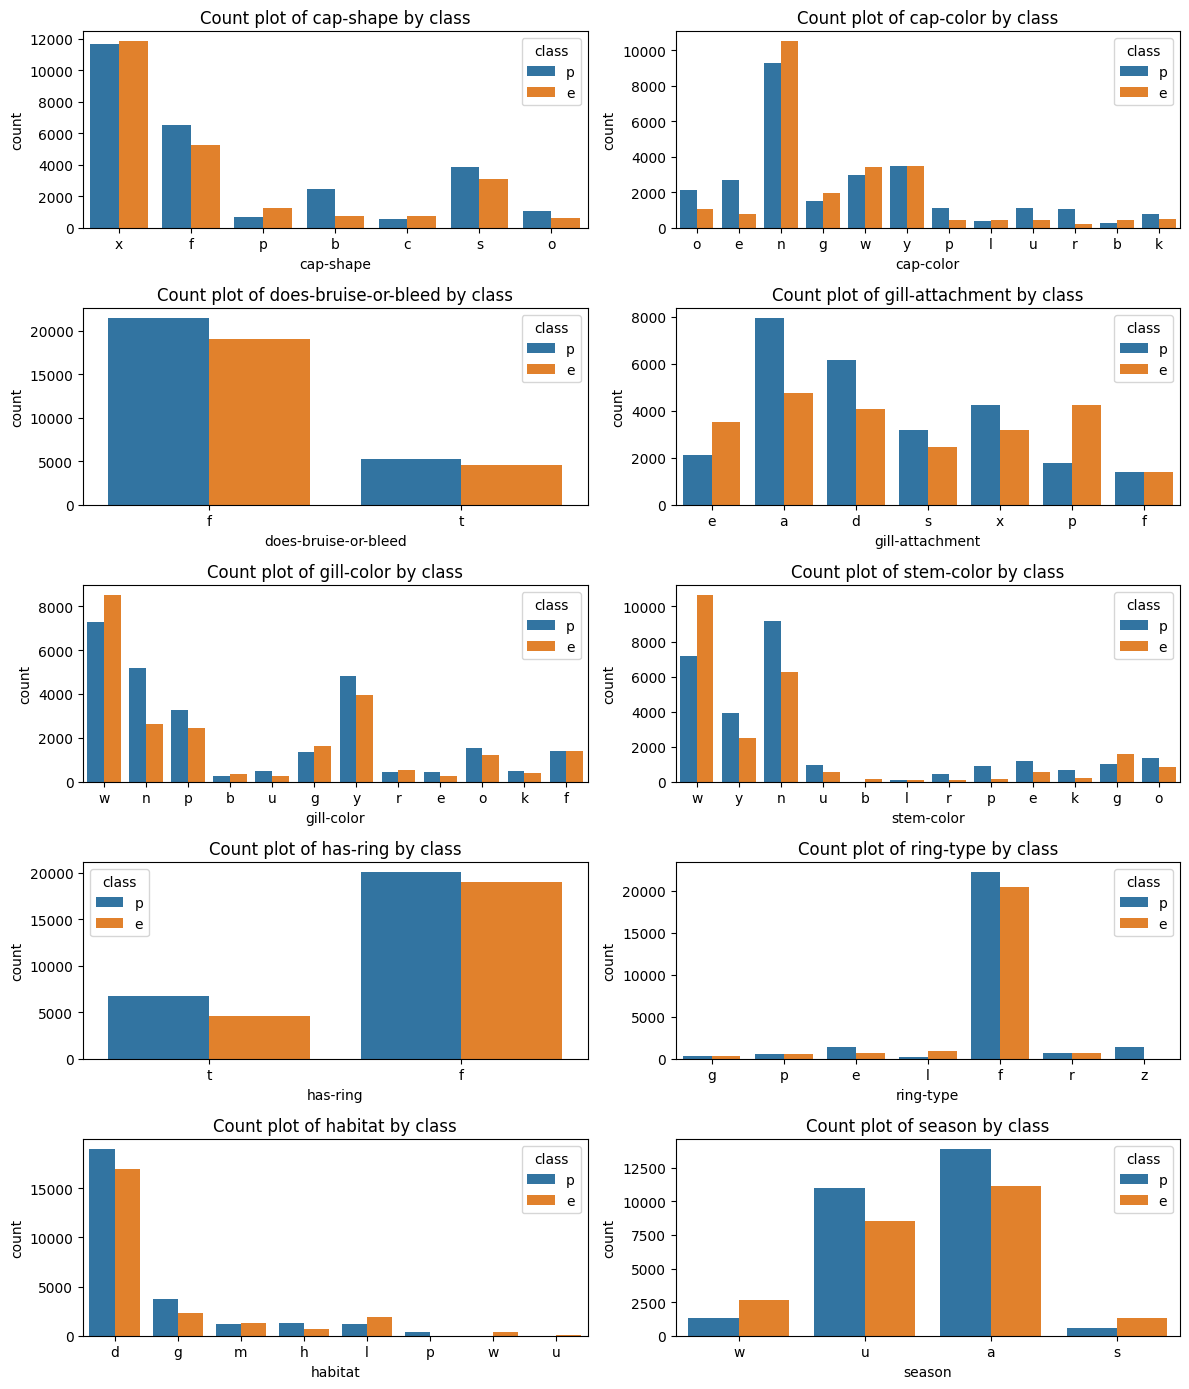

In [28]:
cat_col_feat = ['cap-shape', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-color', 'stem-color', 'has-ring', 'ring-type',
       'habitat', 'season']

fig, axes = plt.subplots(5, 2, figsize=(12,14))
axes = axes.flatten()

for i, col in enumerate(cat_col_feat):
  sns.countplot(data=df, x=col, hue="class", ax=axes[i])
  axes[i].set_title(f'Count plot of {col} by class')

plt.tight_layout()
plt.show()

not really informative graph to us, because we cannot identify any significant influences that affect the class. But we can see what categories we have in each column and we know how to deal with that for modeling.

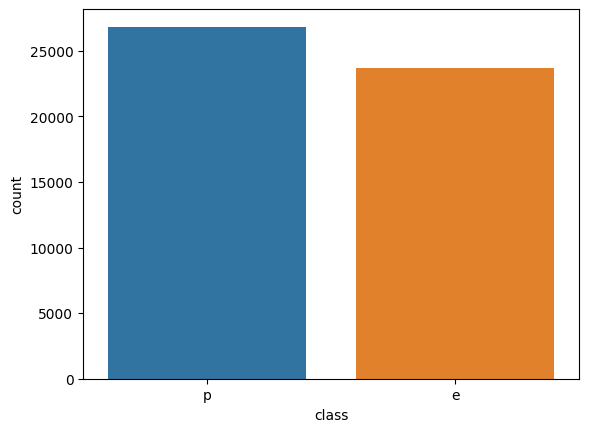

In [29]:
# also let's see class column
sns.countplot(data=df, x="class", hue="class")
plt.show()

we can see a slight class imbalance

# Feature encodings

In [30]:
# for binary features we will use one-hot encoding
# for other categorical data will use dummy variables

df["has-ring"] = pd.factorize(df["has-ring"])[0]
df["does-bruise-or-bleed"] = pd.factorize(df["does-bruise-or-bleed"])[0]

other_cat_categories = ['cap-shape', 'cap-color', 'gill-attachment',
                        'gill-color', 'stem-color', 'ring-type', 'habitat',
                        'season']

dummies = pd.get_dummies(df[other_cat_categories], dtype=float, drop_first=True)
df = pd.concat([df.drop(columns=other_cat_categories), dummies], axis=1)

In [31]:
# here we get 0 as poisonous and 1 as edible mushrooms
df["class"] = pd.factorize(df["class"])[0]

In [32]:
df.head()

,class,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,...,habitat_g,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_s,season_u,season_w
0,0,15.26,0,16.95,17.09,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,16.60,0,17.99,18.19,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,14.07,0,17.80,17.74,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,14.17,0,15.77,15.98,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,14.64,0,16.53,17.20,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modeling

In [33]:
# make train/ test data
X = df.drop(columns="class")
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
models = {
    "LogisticRegression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    'SVC': SVC(),
    "LightGBM": lgb.LGBMClassifier(verbose=-1),
    "XGBoost": xgb.XGBClassifier(),
    "GradientBoostingClassifier" : GradientBoostingClassifier(),
    "ADA Boost" : AdaBoostClassifier(),
    "KNN" : KNeighborsClassifier(),
    "Gaussian" : GaussianNB()
}

evaluation_df = pd.DataFrame({
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Average Precision": [],
    "F-score": [],
    "ROC-AUC": [],
    "Training Time (s)": []
})

In [40]:
np.random.seed(42)

for name, model in models.items():
  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()

  pred = model.predict(X_test)

  training_time = end_time - start_time
  print(f"{name} training is finished!")
  print("Confusion matrix is: ")
  print(pd.DataFrame(confusion_matrix(y_test, pred)))
  print(f"Spended time: {training_time}")
  print("~"*50)
  print("\n")

  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  avg_precision = average_precision_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred)


  new_row = pd.DataFrame({
      "Model": [name],
      "Accuracy": [accuracy],
      "Precision": [precision],
      "Average Precision": [avg_precision],
      "F-score": [f1],
      "ROC-AUC": [roc_auc],
      "Training Time (s)": [training_time]
  })

  evaluation_df = pd.concat([evaluation_df, new_row], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression training is finished!
Confusion matrix is: 
      0     1
0  3929  1433
1  1235  3499
Spended time: 1.917550802230835
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Decision Tree training is finished!
Confusion matrix is: 
      0     1
0  5325    37
1    31  4703
Spended time: 0.46481847763061523
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Random Forest training is finished!
Confusion matrix is: 
      0     1
0  5355     7
1     9  4725
Spended time: 5.185777902603149
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


SVC training is finished!
Confusion matrix is: 
      0     1
0  4838   524
1   821  3913
Spended time: 131.93939924240112
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


LightGBM training is finished!
Confusion matrix is: 
      0     1
0  5341    21
1    26  4708
Spended time: 0.6627881526947021
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


XGBoost training is finished!
Confusion matrix is: 
      0     1
0  5351    11
1

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ADA Boost training is finished!
Confusion matrix is: 
      0     1
0  4195  1167
1  1013  3721
Spended time: 2.212214231491089
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


KNN training is finished!
Confusion matrix is: 
      0     1
0  5342    20
1    27  4707
Spended time: 0.018723249435424805
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Gaussian training is finished!
Confusion matrix is: 
      0     1
0  2669  2693
1   920  3814
Spended time: 0.06019997596740723
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [42]:
# result of modeling
evaluation_df.sort_values(by="Precision", ascending=False)

,Model,Accuracy,Precision,Average Precision,F-score,ROC-AUC,Training Time (s)
2,Random Forest,0.998415,0.998521,0.997514,0.998310,0.998397,5.185778
5,XGBoost,0.997821,0.997676,0.996448,0.997676,0.997812,1.037126
8,KNN,0.995345,0.995769,0.992764,0.995032,0.995283,0.018723
4,LightGBM,0.995345,0.995559,0.992667,0.995033,0.995296,0.662788
1,Decision Tree,0.993265,0.992194,0.988767,0.992822,0.993276,0.464818
6,GradientBoostingClassifier,0.924128,0.932244,0.887710,0.917846,0.922943,9.675702
3,SVC,0.866779,0.881902,0.810277,0.853342,0.864424,131.939399
7,ADA Boost,0.784073,0.761252,0.698693,0.773436,0.784187,2.212214
0,LogisticRegression,0.735737,0.709448,0.646694,0.723981,0.735935,1.917551
9,Gaussian,0.642135,0.586138,0.563354,0.678587,0.651712,0.060200


Very interesting results, we have good metrics from RandomForest, XGBoost, LightGBM, DecisionTree and default KNN, what is impress the most to be honest. Naive Bayes was used as an example because we cannot claim that every event (feature) is independent, so that why we have metrics a bit higher than 50%. Here we will not focus too much on the training time and will give the victory to Random Forest for the larger precision what is really important in our situation.

In [43]:
# let's make cross-validation to see average metrics for RandomForest

selected_model = RandomForestClassifier()

s_kf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

val_f_score = cross_val_score(selected_model, X, y, cv=s_kf, scoring="f1")
val_avg_precsion = cross_val_score(selected_model, X, y, cv=s_kf, scoring="average_precision")
val_roc_auc = cross_val_score(selected_model, X, y, cv=s_kf, scoring="roc_auc")
val_loss = cross_val_score(selected_model, X, y, cv=s_kf, scoring="neg_log_loss")

print("RandomForest cross-validation test")
print("~"*50)
print(f"Average F-score: {np.average(val_f_score)}")
print(f"Average of average percision score: {np.average(val_avg_precsion)}")
print(f"Average ROC-AUC: {np.average(val_roc_auc)}")
print(f"Average Cross-Entropy: {-np.average(val_loss)}")

RandomForest cross-validation test
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Average F-score: 0.9980536479513008
Average of average percision score: 0.9998737391009438
Average ROC-AUC: 0.9998928043702081
Average Cross-Entropy: 0.01606525582705777


After cross validation test with RandomForest we still get really impressive metrics, what means that previous modeling wasn't just lucky random seed.

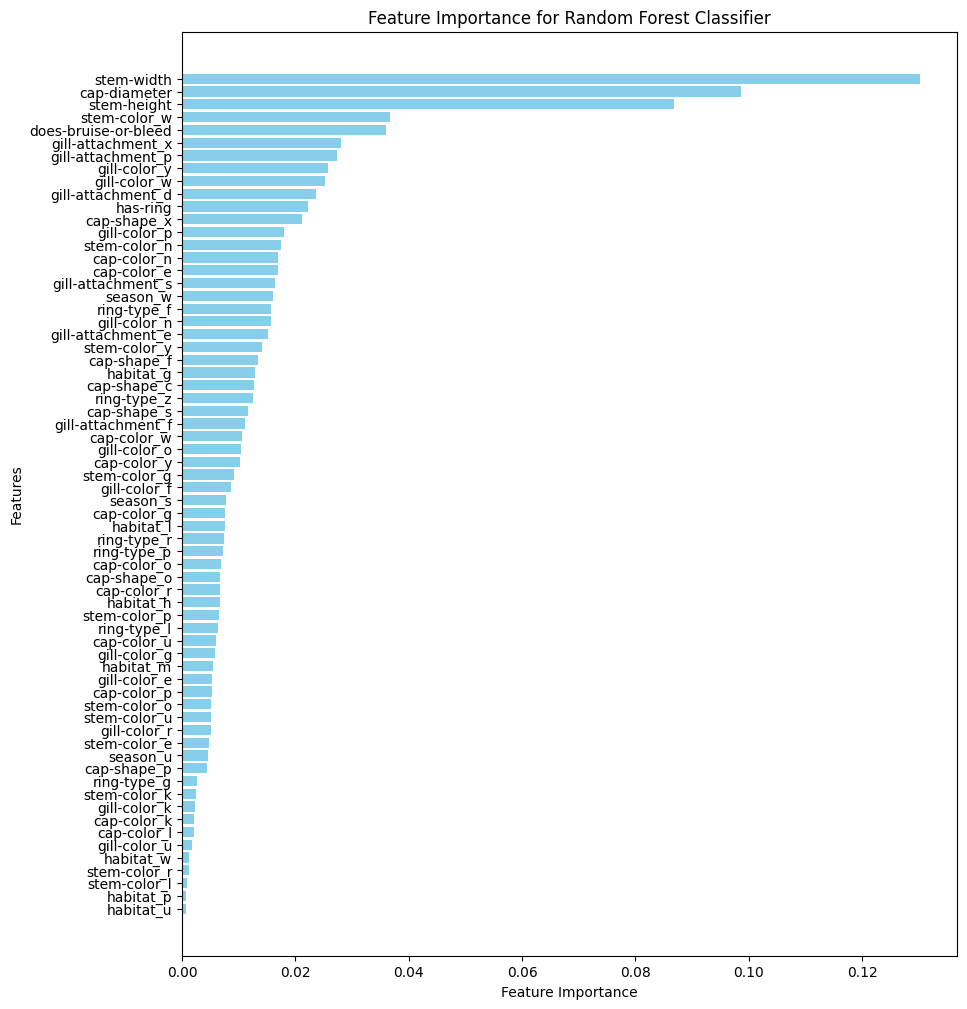

In [44]:
# also can see what importance of each feature in ensemble models like RandomForest
selected_model.fit(X_train, y_train)

importances = selected_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 12))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Random Forest Classifier")
plt.gca().invert_yaxis()
plt.show()